# What part of the sim takes the most time?
*And how do we optimize?*
## 0. Imports

In [1]:
import sys
sys.path.append("../")

from surface import *
from source import *
from model import *

import numpy as np
from time import process_time as Time

## 1. Define surface

In [2]:
# surface
surf = Surface(origin=(0, 0), dims=(101, 101), fs=100)
surf.gen_flat(-10)

## 2. Create sources along a transit

In [3]:
# source
ss = []
n = 20
f0 = 9e6
dt = 1 / (8 * f0)
for x in np.linspace(0, 10000, n):
    source = Source(dt, 0.5e-6, (x, 5050, 25000))
    source.chirp(f0, 1e6)
    ss.append(source)

## 3. Create models and simulate for each source location

In [4]:
ms = []
st = Time()
setups, raypaths, dopplers, tss = [], [], [], []
for i, s in enumerate(ss):
    print(f"Simulating: {i+1}/{len(ss)} ({round(100*((i+1)/len(ss)), 1)}%)", end="     \r")
    nt = Time()
    model = Model(surf, s)
    model.set_target((5050, 5050, -200))    # set target location
    setups.append(Time() - nt)
    #model.gen_raypaths_new()
    nt = Time()
    model.gen_raypaths()    # generate raypaths
    raypaths.append(Time() - nt)
    nt = Time()
    model.comp_dopplers()
    dopplers.append(Time() - nt)
    nt = Time()
    model.gen_timeseries(show=False)    # simulate
    tss.append(Time() - nt)
    ms.append(model)
print(f"\n\nTotal processing time: {round((Time() - st)/60)} minutes and {round((Time() - st) % 60,2)} seconds")

Simulating: 20/20 (100.0%)     

Total processing time: 1 minutes and 30.2 seconds


## 4. Plot Timing

In [5]:
import matplotlib.pyplot as plt

In [6]:
# load pre optimized results
dat = np.load("pre-optimized.npy")

In [7]:
labels = ["Setup", "Raypaths", "Dopplers", "Time Series"]

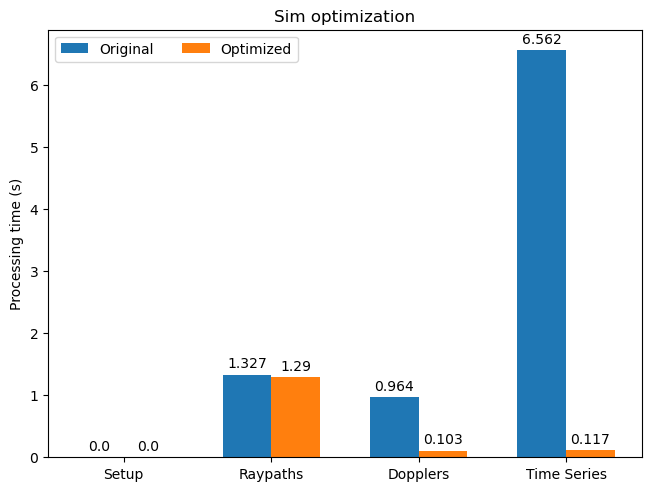

In [8]:
means = {
    'Original': np.mean(dat, axis=1),
    'Optimized': [np.mean(setups), np.mean(raypaths), np.mean(dopplers), np.mean(tss)],
}

x = np.arange(len(labels))  # the label locations
width = 0.33  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, np.round(measurement, 3), padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Processing time (s)')
ax.set_title('Sim optimization')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)

plt.show()